<a href="https://colab.research.google.com/github/cgrundman/ml-stethoscope/blob/main/code/003_Machine_Learned_Stethoscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine-Learned Stethoscope

Authored by 

from: https://www.kaggle.com/code/eatmygoose/cnn-detection-of-wheezes-and-crackles

## Import Statements

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
import wave
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Load Data

In [5]:
os.listdir('/content/drive/MyDrive/Machine Learned Stethoscope/Dataset/Respiratory_Sound_Database')

['demographic_info.txt',
 'filename_format.txt',
 'filename_differences.txt',
 'patient_diagnosis.csv',
 'audio_and_txt_files']

In [6]:
df_no_diagnosis = pd.read_csv('/content/drive/MyDrive/Machine Learned Stethoscope/Dataset/Respiratory_Sound_Database/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('/content/drive/MyDrive/Machine Learned Stethoscope/Dataset/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [7]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [8]:
root = '/content/drive/MyDrive/Machine Learned Stethoscope/Dataset/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

## Handle the Data

### Sort the Data

In this section, we create lists of the data to create a better model. This section create a series of lists from the data and labels available in this dataset. We create a list of all of the data present in all files, compile this imformation into a list for overall labels, and create a data base based on wheeze and crackle information.

In [9]:
# Extract the data for every file, sound and txt files
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], 
                                  columns = ['Patient number', 
                                             'Recording index', 
                                             'Chest location',
                                             'Acquisition mode',
                                             'Recording equipment'])
    # .txt file information
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), 
                                        names = ['Start', 
                                                 'End', 
                                                 'Crackles', 
                                                 'Wheezes'], 
                                        delimiter= '\t')
    return (recording_info, recording_annotations)

In [10]:
# Initialize lists and dictionaries
info_list = []
rec_annotations = [] 
rec_annotations_dict = {} # rec_dictionary

# Populate lists and dictionaries
for filename in filenames:
    (rec_info,annotations) = Extract_Annotation_Data(filename, root)
    info_list.append(rec_info)
    rec_annotations.append(annotations)
    rec_annotations_dict[filename] = annotations

# Concatinate 
recording_info = pd.concat(info_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,160,1b3,Ar,mc,AKGC417L
0,160,1b3,Lr,mc,AKGC417L
0,160,1b4,Ar,mc,AKGC417L
0,160,1b3,Tc,mc,AKGC417L
0,160,1b3,Pr,mc,AKGC417L


In [11]:
# Initialize lists
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []

# Label all the data based on wheeze and crackle annotations
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [12]:
# Create a dataframe based on wheeze and crackle labels
file_label_df = pd.DataFrame(data = {'filename':filename_list, 
                                     'no label':no_label_list, 
                                     'crackles only':crack_list, 
                                     'wheezes only':wheeze_list, 
                                     'crackles and wheezees':both_sym_list})

In [13]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]

# Display totals of the file labels
file_label_df.sum()

filename                 160_1b3_Ar_mc_AKGC417L160_1b3_Lr_mc_AKGC417L16...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

### Read .wav Files

In this section, we define the utility functions for reading .wav files (especially 24bit .wav). The audio data has been taken from multiple devices having differing sampling rates. We resample all the data to the same rate in order to train our model.

24bit sample rates are so chalenging, because it is not a bit-wise multple (or pwer of 2). This extrapolates this data to match the other sources. Making tha sample rate to a base 2 creates an even relationship in steps and second.

In [14]:
import wave
import math
import scipy.io.wavfile as wf

# Read the wave files and return a 32bit array float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav, str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

# Resample all files to the target sample rate
def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# Extract .wav data into float array
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) # clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        # 24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
# Truncate the 24bit samples to 16bit precision, only needed for 24bit files
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)

    # Return numpy array to save memory via array slicing
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  
    
# Find bitrate for certain .wav file
def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) # bytes per sample
    return (bps, lp_wave.getnchannels())

# Split data into section defined by start and end
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

### Distribution of respiratory cycle lengths

longest cycle:16.163
shortest cycle:0.1999999999999993
Fraction of samples less than 5 seconds:0.9660771238040011


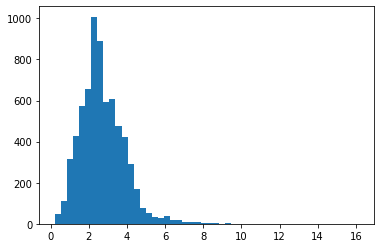

In [15]:
# Initialize list
duration_list = []

# Populate list of recording durations
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

# Display of the delay times max, min, and cutoff
duration_list = np.array(duration_list) # convert list to np array
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold, np.sum(duration_list < threshold)/len(duration_list)))

## Data Augmentation

### Melspectrogram implementation (With VTLP)

This section creates Melspectrograms created based on the work of Jaitly & Hinton (2013). To read more about this:
https://www.cs.utoronto.ca/~hinton/absps/perturb.pdf
The overall purpose of this code is to convert audio samples into a Mel-frequency spectrogram, which is a representation of the audio in the Mel-frequency domain. This is a common step in speech and audio processing for feature extraction and analysis.

In [16]:
import scipy.signal

# Trun a sample into a melsprectrum
def sample2MelSpectrum(cycle_info, sample_rate, n_filters, vtlp_params):
    n_rows = 175 # 7500 cutoff
    n_window = 512 #~25 ms window
    (f, t, Sxx) = scipy.signal.spectrogram(cycle_info[0],fs = sample_rate, nfft= n_window, nperseg=n_window)
    Sxx = Sxx[:n_rows,:].astype(np.float32) # sift out coefficients above 7500hz, Sxx has 196 columns
    mel_log = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters, vtlp_params)[1]
    mel_min = np.min(mel_log)
    mel_max = np.max(mel_log)
    diff = mel_max - mel_min
    norm_mel_log = (mel_log - mel_min) / diff if (diff > 0) else np.zeros(shape = (n_filters,Sxx.shape[1]))
    if (diff == 0):
        print('Error: sample data is completely empty')
    labels = [cycle_info[1], cycle_info[2]] # crackles, wheezes flags
    return (np.reshape(norm_mel_log, (n_filters,Sxx.shape[1],1)).astype(np.float32), # 196x64x1 matrix
            label2onehot(labels)) 

# Calculate frequency into melspectrum space
def Freq2Mel(freq):
    return 1125 * np.log(1 + freq / 700)

# Calculate melspectrum space back into frequency
def Mel2Freq(mel):
    exponents = mel / 1125
    return 700 * (np.exp(exponents) - 1)

# Takes an array of original mel  frequencies and returns warped version of them using vocal tract length normalization (VTLN)
def VTLP_shift(mel_freq, alpha, f_high, sample_rate):
    nyquist_f = sample_rate / 2
    warp_factor = min(alpha, 1)
    threshold_freq = f_high * warp_factor / alpha
    lower = mel_freq * alpha
    higher = nyquist_f - (nyquist_f - mel_freq) * ((nyquist_f - f_high * warp_factor) / (nyquist_f - f_high * (warp_factor / alpha)))
    
    warped_mel = np.where(mel_freq <= threshold_freq, lower, higher)
    return warped_mel.astype(np.float32)

# mel_space_freq: the mel frequencies (HZ) of the filter banks, in addition to 
#                 the two maximum and minimum frequency values
# fft_bin_frequencies: the bin freqencies of the FFT output
# Generates a 2d numpy array, with each row containing each filter bank
def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    #Triangular filter windows
    #ripped from http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
    for mel_index in range(n_filters):
        m = int(mel_index + 1)
        filter_bank = []
        for f in fft_bin_frequencies:
            if(f < mel_space_freq[m-1]):
                hm = 0
            elif(f < mel_space_freq[m]):
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif(f < mel_space_freq[m + 1]):
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m + 1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    return np.array(coeff, dtype = np.float32)
        
#Transform spectrogram into mel spectrogram -> (frequencies, spectrum)
#vtlp_params = (alpha, f_high), vtlp will not be applied if set to None
def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks, vtlp_params = None):
    (max_mel, min_mel)  = (Freq2Mel(max(f)), Freq2Mel(min(f)))
    mel_bins = np.linspace(min_mel, max_mel, num = (n_filterbanks + 2))
    #Convert mel_bins to corresponding frequencies in hz
    mel_freq = Mel2Freq(mel_bins)
    
    if(vtlp_params is None):
        filter_banks = GenerateMelFilterBanks(mel_freq, f)
    else:
        #Apply VTLP
        (alpha, f_high) = vtlp_params
        warped_mel = VTLP_shift(mel_freq, alpha, f_high, sample_rate)
        filter_banks = GenerateMelFilterBanks(warped_mel, f)
        
    mel_spectrum = np.matmul(filter_banks, Sxx)
    return (mel_freq[1:-1], np.log10(mel_spectrum  + float(10e-12)))
    
# Labels proved too difficult to train (model keep convergining to statistical mean)
# Flattened to onehot labels since the number of combinations is very low
def label2onehot(c_w_flags):
    c = c_w_flags[0]
    w = c_w_flags[1]
    if((c == False) & (w == False)):
        return [1,0,0,0]
    elif((c == True) & (w == False)):
        return [0,1,0,0]
    elif((c == False) & (w == True)):
        return [0,0,1,0]
    else:
        return [0,0,0,1]

### Data preparation utility functions

In [17]:
# Used to split each individual sound file into separate sound clips containing one respiratory cycle each
# output: [filename, (sample_data:np.array, start:float, end:float, crackles:bool(float), wheezes:bool(float)) (...) ]
def get_sound_samples(recording_annotations, file_name, root, sample_rate):
    sample_data = [file_name]
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    
    for i in range(len(recording_annotations.index)):
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk, start,end,crackles,wheezes))
    return sample_data

#Fits each respiratory cycle into a fixed length audio clip, splits may be performed and zero padding is added if necessary
#original:(arr,c,w) -> output:[(arr,c,w),(arr,c,w)]
def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original[0]
    n_samples = len(soundclip)
    total_length = n_samples / sampleRate #length of cycle in seconds
    n_slices = int(math.ceil(total_length / desiredLength)) #get the minimum number of slices needed
    samples_per_slice = n_samples // n_slices
    src_start = 0 #Staring index of the samples to copy from the original buffer
    output = [] #Holds the resultant slices
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

### Data augmentation
Two basic forms employed : audio stretching (speeding up or down) as well as Vocal Tract Length perturbation

In [18]:
#Creates a copy of each time slice, but stretches or contracts it by a random amount
def gen_time_stretch(original, sample_rate, max_percent_change):
    stretch_amount = 1 + np.random.uniform(-1,1) * (max_percent_change / 100)
    (_, stretched) = resample(sample_rate, original, int(sample_rate * stretch_amount)) 
    return stretched

#Same as above, but applies it to a list of samples
def augment_list(audio_with_labels, sample_rate, percent_change, n_repeats):
    augmented_samples = []
    for i in range(n_repeats):
        addition = [(gen_time_stretch(t[0], sample_rate, percent_change), t[1], t[2] ) for t in audio_with_labels]
        augmented_samples.extend(addition)
    return augmented_samples

#Takes a list of respiratory cycles, and splits and pads each cycle into fixed length buffers (determined by desiredLength(seconds))
#Then takes the split and padded sample and transforms it into a mel spectrogram
#VTLP_alpha_range = [Lower, Upper] (Bounds of random selection range), 
#VTLP_high_freq_range = [Lower, Upper] (-)
#output:[(arr:float[],c:float_bool,w:float_bool),(arr,c,w)]
def split_and_pad_and_apply_mel_spect(original, desiredLength, sampleRate, VTLP_alpha_range = None, VTLP_high_freq_range = None, n_repeats = 1):
    output = []
    for i in range(n_repeats):
        for d in original:
            lst_result = split_and_pad(d, desiredLength, sampleRate) #Time domain
            if( (VTLP_alpha_range is None) | (VTLP_high_freq_range is None) ):
                #Do not apply VTLP
                VTLP_params = None
            else:
                #Randomly generate VLTP parameters
                alpha = np.random.uniform(VTLP_alpha_range[0], VTLP_alpha_range[1])
                high_freq = np.random.uniform(VTLP_high_freq_range[0], VTLP_high_freq_range[1])
                VTLP_params = (alpha, high_freq)
            freq_result = [sample2MelSpectrum(d, sampleRate, 50, VTLP_params) for d in lst_result] #Freq domain
            output.extend(freq_result)
    return output

163


Text(0.5, 1.0, 'With VTLP')

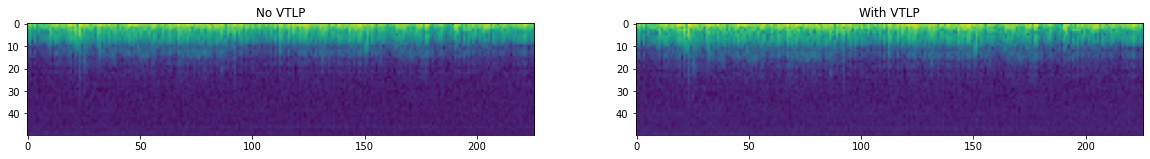

In [19]:
#
str_file = filenames[11]
lp_test = get_sound_samples(rec_annotations_dict[str_file], str_file, root, 22000)
lp_cycles = [(d[0], d[3], d[4]) for d in lp_test[1:]]
soundclip = lp_cycles[1][0]

n_window = 512
sample_rate = 22000
(f, t, Sxx) = scipy.signal.spectrogram(soundclip, fs = 22000, nfft= n_window, nperseg=n_window)
print(sum(f < 7000))
#compare using VTLP and not using it
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
mel_banks = FFT2MelSpectrogram(f[:175], Sxx[:175,:], sample_rate, 50)[1]
plt.imshow(mel_banks, aspect = 1)
plt.title('No VTLP')

plt.subplot(1,2,2)
mel_banks = FFT2MelSpectrogram(f[:175], Sxx[:175,:], sample_rate, 50, vtlp_params = (0.9,3500))[1]
plt.imshow(mel_banks, aspect = 1)
plt.title('With VTLP')

### Utility used to import all training samples

In [20]:
from sklearn.model_selection import train_test_split

def extract_all_training_samples(filenames, annotation_dict, root, target_rate, desired_length, train_test_ratio = 0.2):
    cycle_list = []
    for file in filenames:
        data = get_sound_samples(annotation_dict[file], file, root, target_rate)
        cycles_with_labels = [(d[0], d[3], d[4]) for d in data[1:]]
        cycle_list.extend(cycles_with_labels)
    
    #Sort into respective classes
    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    c_only = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 0))] 
    w_only = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 1))]
    c_w = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 1))]
    
    #Count of labels across all cycles, actual recording time also follows similar ratios
    #none:3642
    #crackles:1864 
    #wheezes:886
    #both:506
    none_train, none_test = train_test_split(no_labels, test_size = train_test_ratio)
    c_train, c_test  = train_test_split(c_only, test_size = train_test_ratio)
    w_train, w_test  = train_test_split(w_only, test_size = train_test_ratio)
    c_w_train, c_w_test  = train_test_split(c_w, test_size = train_test_ratio)
    
    #Training section (Data augmentation procedures)
    #Augment w_only and c_w groups to match the size of c_only
    #no_labels will be artifically reduced in the pipeline  later
    w_stretch = w_train + augment_list(w_train, target_rate, 10 , 1) #
    c_w_stretch = c_w_train + augment_list(c_w_train , target_rate, 10 , 1) 
    
    #Split up cycles into sound clips with fixed lengths so they can be fed into a CNN
    vtlp_alpha = [0.9,1.1]
    vtlp_upper_freq = [3200,3800]
    
    train_none  = (split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate) +
                   split_and_pad_and_apply_mel_spect(none_train, desired_length, target_rate, vtlp_alpha))
    #cracks
    train_c = (split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate) + 
               split_and_pad_and_apply_mel_spect(c_train, desired_length, target_rate, vtlp_alpha, vtlp_upper_freq, n_repeats = 3) ) #original samples + VTLP
    #wheezes
    train_w = (split_and_pad_and_apply_mel_spect(w_stretch, desired_length, target_rate) + 
               split_and_pad_and_apply_mel_spect(w_stretch , desired_length, target_rate, vtlp_alpha , vtlp_upper_freq, n_repeats = 4)) #(original samples + time stretch) + VTLP
    #both
    train_c_w = (split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate) + 
                 split_and_pad_and_apply_mel_spect(c_w_stretch, desired_length, target_rate, vtlp_alpha , vtlp_upper_freq, n_repeats = 7)) #(original samples + time stretch * 2) + VTLP
    
    train_dict = {'none':train_none,'crackles':train_c,'wheezes':train_w, 'both':train_c_w}
    
    #test section 
    test_none  = split_and_pad_and_apply_mel_spect(none_test, desired_length, target_rate)
    test_c = split_and_pad_and_apply_mel_spect(c_test, desired_length, target_rate)
    test_w = split_and_pad_and_apply_mel_spect(w_test, desired_length, target_rate)
    test_c_w = split_and_pad_and_apply_mel_spect(c_w_test, desired_length, target_rate)
    
    test_dict = {'none':test_none,'crackles':test_c,'wheezes':test_w, 'both':test_c_w}
    
    return [train_dict, test_dict]

In [21]:
target_sample_rate = 22000 
sample_length_seconds = 5
sample_dict = extract_all_training_samples(filenames, rec_annotations_dict, root, target_sample_rate, sample_length_seconds) #sample rate lowered to meet memory constraints
training_clips = sample_dict[0]
test_clips = sample_dict[1]

In [22]:
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                        len(src_dict['crackles']),
                                                        len(src_dict['wheezes']),
                                                        len(src_dict['both'])))

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6070
crackles:6024
wheezes:7245
both:6776

[Test set]
none:768
crackles:382
wheezes:186
both:111


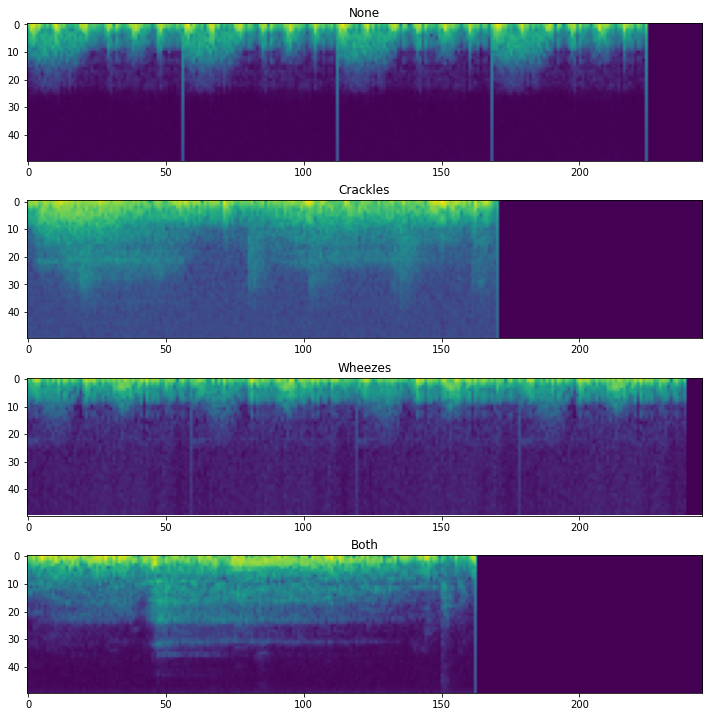

In [23]:
#Example of tiled sound samples
sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 1
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

### Data Pipeline

In [24]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    #In summary, this generator function generates a batch of data for training a Keras model by
    # randomly selecting clips from the four classes, applying a rollFFT function on them and returning
    # the resulting data and labels in a format that can be fed into a Keras model.
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [25]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1])
test_gen = feed_all([none_test, c_test, w_test,c_w_test])

## CNN implementation

### Model 1

In [26]:
batch_size = 128
n_epochs = 30

In [27]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
K.clear_session()

model_1 = Sequential()
model_1.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model_1.add(LeakyReLU(alpha = 0.1))
model_1.add(MaxPool2D(padding = 'SAME')) # "SAME" = with zero padding

model_1.add(Conv2D(256, [5,5], padding = 'SAME'))
model_1.add(LeakyReLU(alpha = 0.1))
model_1.add(MaxPool2D(padding = 'SAME'))

model_1.add(Conv2D(256, [1,1], padding = 'SAME'))
model_1.add(Conv2D(256, [3,3], padding = 'SAME'))
model_1.add(LeakyReLU(alpha = 0.1))
model_1.add(MaxPool2D(padding = 'SAME'))

# model_1.add(Conv2D(512, [1,1], padding = 'SAME'))
# model_1.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
# model_1.add(MaxPool2D(padding = 'SAME'))

model_1.add(Conv2D(512, [1,1], padding = 'SAME'))
model_1.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model_1.add(MaxPool2D(padding = 'SAME'))
model_1.add(Flatten())

model_1.add(Dense(4096, activation = 'relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(512, activation = 'relu'))
model_1.add(Dense(4, activation = 'softmax'))

# "SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
# it will add the extra column to the right, as is the case in this example 
# (the same logic applies vertically: there may be an extra row of zeros at the bottom).

opt = optimizers.Adam(learning_rate=0.0001, 
                      beta_1=0.9, 
                      beta_2=0.999, 
                      epsilon=None, 
                      decay=0.00, 
                      amsgrad=False)

model_1.compile(optimizer=opt, 
                loss='categorical_crossentropy', 
                metrics=['acc'])

log_dir = "logs/fit/model_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 123, 128)      9984      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25, 123, 128)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 62, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 62, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 62, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 31, 256)       0         
 2D)                                                    

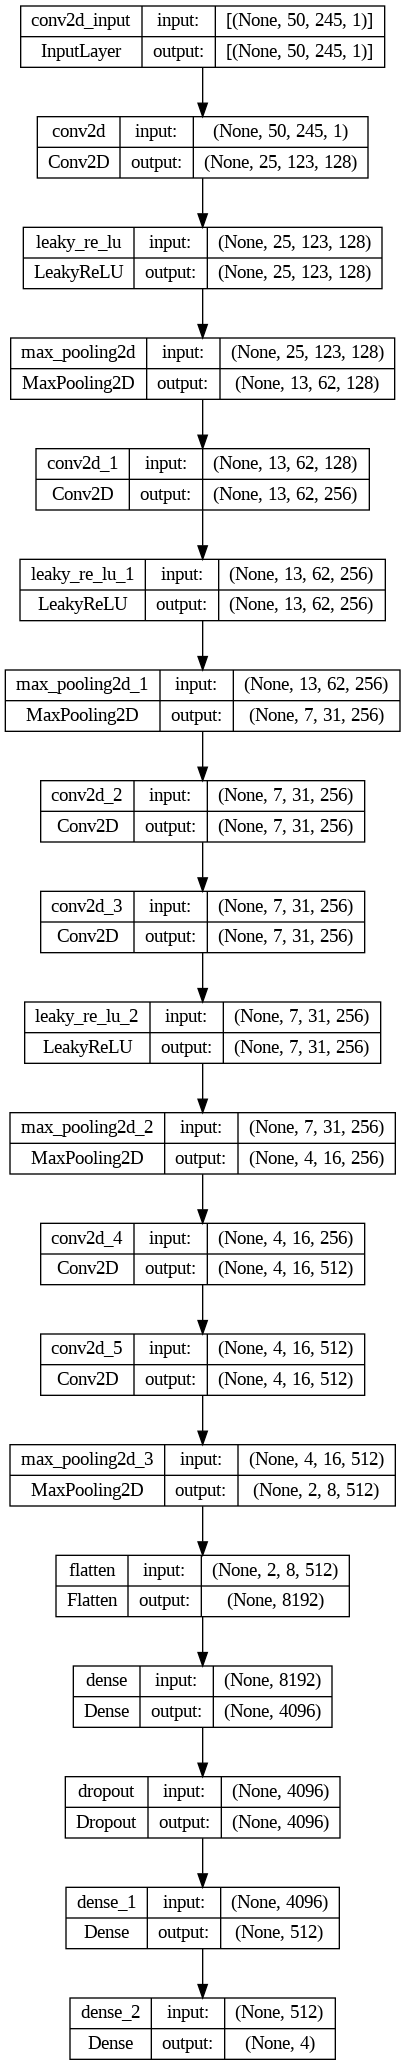

In [30]:
from keras.utils.vis_utils import plot_model

plot_model(model_1, show_shapes=True, show_layer_names = True)

In [ ]:
stats_1 = model_1.fit_generator(generator = train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/30


<ipython-input-59-9c245da00d30>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  stats_1 = model_1.fit_generator(generator = train_gen.generate_keras(batch_size),


188/188 [==============================] - 22s 115ms/step - loss: 1.2980 - acc: 0.3804 - val_loss: 1.1923 - val_acc: 0.4730
Epoch 2/30
188/188 [==============================] - 23s 120ms/step - loss: 1.1517 - acc: 0.4931 - val_loss: 1.0355 - val_acc: 0.5540
Epoch 3/30
188/188 [==============================] - 22s 118ms/step - loss: 1.0337 - acc: 0.5570 - val_loss: 1.1245 - val_acc: 0.5213
Epoch 4/30
188/188 [==============================] - 22s 115ms/step - loss: 0.9337 - acc: 0.6006 - val_loss: 0.9257 - val_acc: 0.6072
Epoch 5/30
188/188 [==============================] - 22s 115ms/step - loss: 0.8261 - acc: 0.6559 - val_loss: 0.9257 - val_acc: 0.6037
Epoch 6/30
188/188 [==============================] - 22s 117ms/step - loss: 0.7325 - acc: 0.7012 - val_loss: 0.8482 - val_acc: 0.6371
Epoch 7/30
188/188 [==============================] - 22s 116ms/step - loss: 0.6510 - acc: 0.7363 - val_loss: 0.8650 - val_acc: 0.6470
Epoch 8/30
188/188 [==============================] - 22s 116ms/st

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model_1.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

45/45 [==============================] - 1s 21ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

        none       0.82      0.85      0.83       766
    crackles       0.69      0.69      0.69       380
     wheezes       0.65      0.65      0.65       181
        both       0.59      0.44      0.51       108

    accuracy                           0.75      1435
   macro avg       0.69      0.66      0.67      1435
weighted avg       0.75      0.75      0.75      1435

[[649  81  27   9]
 [ 91 263  13  13]
 [ 45   7 117  12]
 [ 10  28  22  48]]


### Model 2

In [31]:
batch_size = 128
n_epochs = 30

In [34]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
K.clear_session()

model_2 = Sequential()
model_2.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model_2.add(LeakyReLU(alpha = 0.1))
model_2.add(MaxPool2D(padding = 'SAME')) # "SAME" = with zero padding

model_2.add(Conv2D(256, [5,5], padding = 'SAME'))
model_2.add(LeakyReLU(alpha = 0.1))
model_2.add(MaxPool2D(padding = 'SAME'))

model_2.add(Conv2D(256, [1,1], padding = 'SAME'))
model_2.add(Conv2D(256, [3,3], padding = 'SAME'))
model_2.add(LeakyReLU(alpha = 0.1))
model_2.add(MaxPool2D(padding = 'SAME'))

model_2.add(Conv2D(512, [1,1], padding = 'SAME'))
model_2.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
# model_2.add(MaxPool2D(padding = 'SAME'))

model_2.add(Conv2D(512, [1,1], padding = 'SAME'))
model_2.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model_2.add(MaxPool2D(padding = 'SAME'))
model_2.add(Flatten())

model_2.add(Dense(4096, activation = 'relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(512, activation = 'relu'))
model_2.add(Dense(4, activation = 'softmax'))

# "SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
# it will add the extra column to the right, as is the case in this example 
# (the same logic applies vertically: there may be an extra row of zeros at the bottom).

opt = optimizers.Adam(learning_rate=0.0001, 
                      beta_1=0.9, 
                      beta_2=0.999, 
                      epsilon=None, 
                      decay=0.00, 
                      amsgrad=False)

model_2.compile(optimizer=opt, 
                loss='categorical_crossentropy', 
                metrics=['acc'])

log_dir = "logs/fit/model_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

In [35]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 123, 128)      9984      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25, 123, 128)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 62, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 62, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 62, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 31, 256)       0         
 2D)                                                    

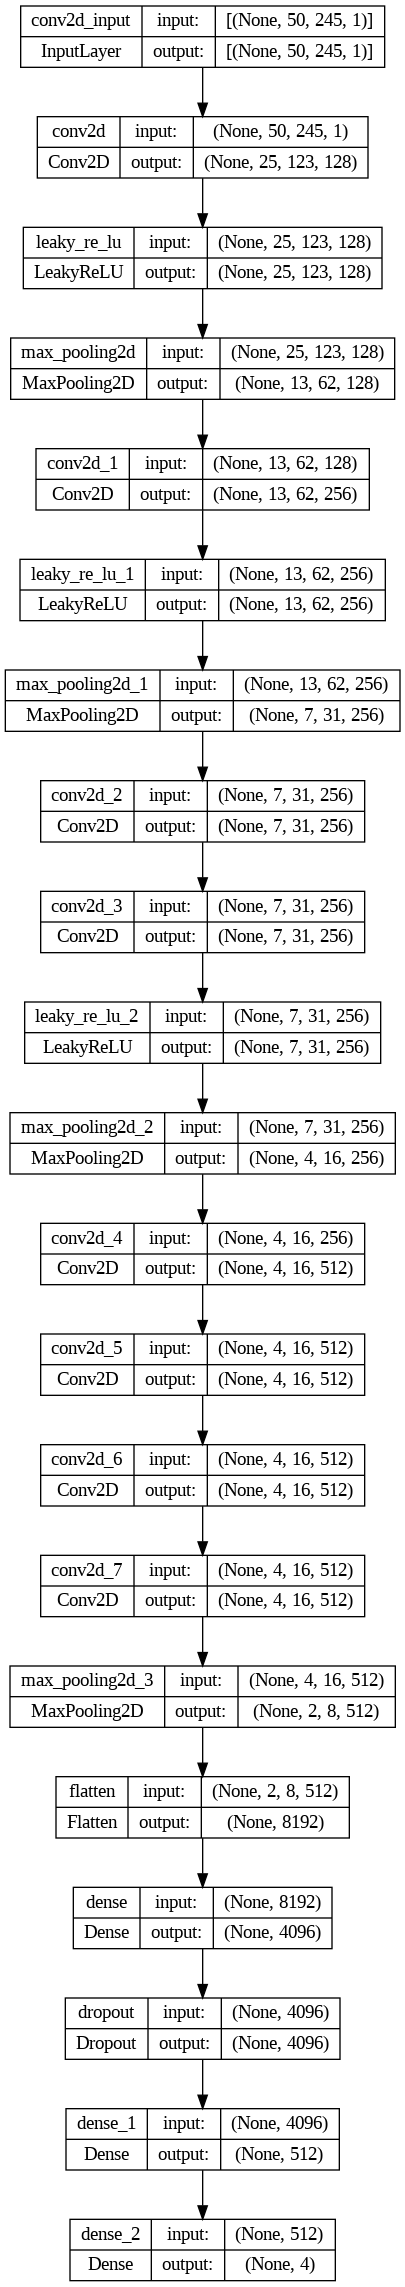

In [36]:
from keras.utils.vis_utils import plot_model

plot_model(model_2, show_shapes=True, show_layer_names = True)

In [ ]:
stats_2 = model_2.fit_generator(generator = train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/30


<ipython-input-34-120983c8ba5e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  stats_2 = model_2.fit_generator(generator = train_gen.generate_keras(batch_size),


188/188 [==============================] - 26s 134ms/step - loss: 1.3116 - acc: 0.3641 - val_loss: 1.2732 - val_acc: 0.3736
Epoch 2/30
188/188 [==============================] - 25s 133ms/step - loss: 1.1401 - acc: 0.4933 - val_loss: 1.0403 - val_acc: 0.5526
Epoch 3/30
188/188 [==============================] - 25s 132ms/step - loss: 1.0050 - acc: 0.5668 - val_loss: 1.0201 - val_acc: 0.5689
Epoch 4/30
188/188 [==============================] - 25s 133ms/step - loss: 0.9000 - acc: 0.6131 - val_loss: 1.0257 - val_acc: 0.5661
Epoch 5/30
188/188 [==============================] - 25s 133ms/step - loss: 0.7934 - acc: 0.6665 - val_loss: 0.9122 - val_acc: 0.6300
Epoch 6/30
188/188 [==============================] - 25s 133ms/step - loss: 0.6957 - acc: 0.7182 - val_loss: 0.8726 - val_acc: 0.6541
Epoch 7/30
188/188 [==============================] - 25s 133ms/step - loss: 0.6070 - acc: 0.7541 - val_loss: 0.9148 - val_acc: 0.6506
Epoch 8/30
188/188 [==============================] - 25s 133ms/st

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model_2.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

45/45 [==============================] - 1s 13ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

        none       0.83      0.80      0.81       766
    crackles       0.69      0.72      0.71       380
     wheezes       0.66      0.64      0.65       181
        both       0.49      0.56      0.52       108

    accuracy                           0.74      1435
   macro avg       0.67      0.68      0.67      1435
weighted avg       0.74      0.74      0.74      1435

[[613 101  29  23]
 [ 76 273   9  22]
 [ 42   5 115  19]
 [ 11  14  22  61]]


### Model 3

In [37]:
batch_size = 128
n_epochs = 30

In [38]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
import tensorflow as tf
K.clear_session()

model_3 = Sequential()
model_3.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model_3.add(LeakyReLU(alpha = 0.1))
model_3.add(MaxPool2D(padding = 'SAME')) # "SAME" = with zero padding

model_3.add(Conv2D(256, [5,5], padding = 'SAME'))
model_3.add(LeakyReLU(alpha = 0.1))
model_3.add(MaxPool2D(padding = 'SAME'))

model_3.add(Conv2D(256, [1,1], padding = 'SAME'))
model_3.add(Conv2D(256, [3,3], padding = 'SAME'))
model_3.add(LeakyReLU(alpha = 0.1))
model_3.add(MaxPool2D(padding = 'SAME'))

model_3.add(Conv2D(512, [1,1], padding = 'SAME'))
model_3.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model_3.add(MaxPool2D(padding = 'SAME'))

model_3.add(Conv2D(512, [1,1], padding = 'SAME'))
model_3.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model_3.add(MaxPool2D(padding = 'SAME'))
model_3.add(Flatten())

model_3.add(Dense(4096, activation = 'relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dense(4, activation = 'softmax'))

# "SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
# it will add the extra column to the right, as is the case in this example 
# (the same logic applies vertically: there may be an extra row of zeros at the bottom).

opt = optimizers.Adam(learning_rate=0.0001, 
                      beta_1=0.9, 
                      beta_2=0.999, 
                      epsilon=None, 
                      decay=0.00, 
                      amsgrad=False)

model_3.compile(optimizer=opt, 
                loss='categorical_crossentropy', 
                metrics=['acc'])

log_dir = "logs/fit/model_3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

In [39]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 123, 128)      9984      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25, 123, 128)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 62, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 62, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 62, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 31, 256)       0         
 2D)                                                    

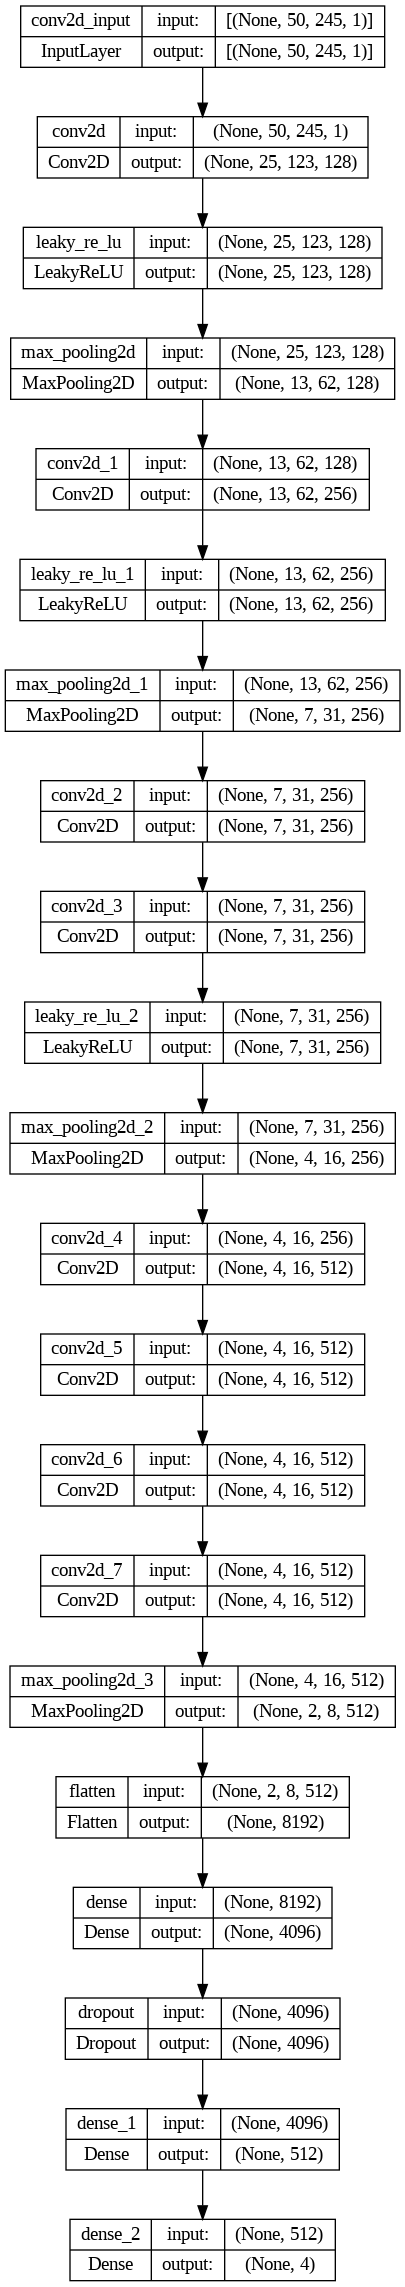

In [40]:
from keras.utils.vis_utils import plot_model

plot_model(model_2, show_shapes=True, show_layer_names = True)

In [ ]:
stats_3 = model_3.fit_generator(generator = train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/30


<ipython-input-64-1f226b5178ed>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  stats_3 = model_3.fit_generator(generator = train_gen.generate_keras(batch_size),


188/188 [==============================] - 23s 116ms/step - loss: 1.3106 - acc: 0.3645 - val_loss: 1.2229 - val_acc: 0.4141
Epoch 2/30
188/188 [==============================] - 23s 120ms/step - loss: 1.1581 - acc: 0.4867 - val_loss: 1.0871 - val_acc: 0.5149
Epoch 3/30
188/188 [==============================] - 22s 118ms/step - loss: 1.0031 - acc: 0.5682 - val_loss: 1.1104 - val_acc: 0.5185
Epoch 4/30
188/188 [==============================] - 22s 115ms/step - loss: 0.8896 - acc: 0.6240 - val_loss: 1.0097 - val_acc: 0.5689
Epoch 5/30
188/188 [==============================] - 22s 116ms/step - loss: 0.7706 - acc: 0.6826 - val_loss: 0.9501 - val_acc: 0.6136
Epoch 6/30
188/188 [==============================] - 22s 118ms/step - loss: 0.6807 - acc: 0.7218 - val_loss: 0.8722 - val_acc: 0.6442
Epoch 7/30
188/188 [==============================] - 22s 116ms/step - loss: 0.5795 - acc: 0.7689 - val_loss: 0.8689 - val_acc: 0.6626
Epoch 8/30
188/188 [==============================] - 22s 116ms/st

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model_2.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

45/45 [==============================] - 1s 13ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

        none       0.82      0.80      0.81       766
    crackles       0.70      0.71      0.70       380
     wheezes       0.66      0.65      0.65       181
        both       0.51      0.59      0.55       108

    accuracy                           0.74      1435
   macro avg       0.67      0.69      0.68      1435
weighted avg       0.75      0.74      0.74      1435

[[613  98  32  23]
 [ 80 270   9  21]
 [ 42   4 117  18]
 [ 10  14  20  64]]


## Model Performance

In [ ]:
# Discover the contents within the stats models
print(stats_1.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


Text(0.5, 0.98, 'Model 3')

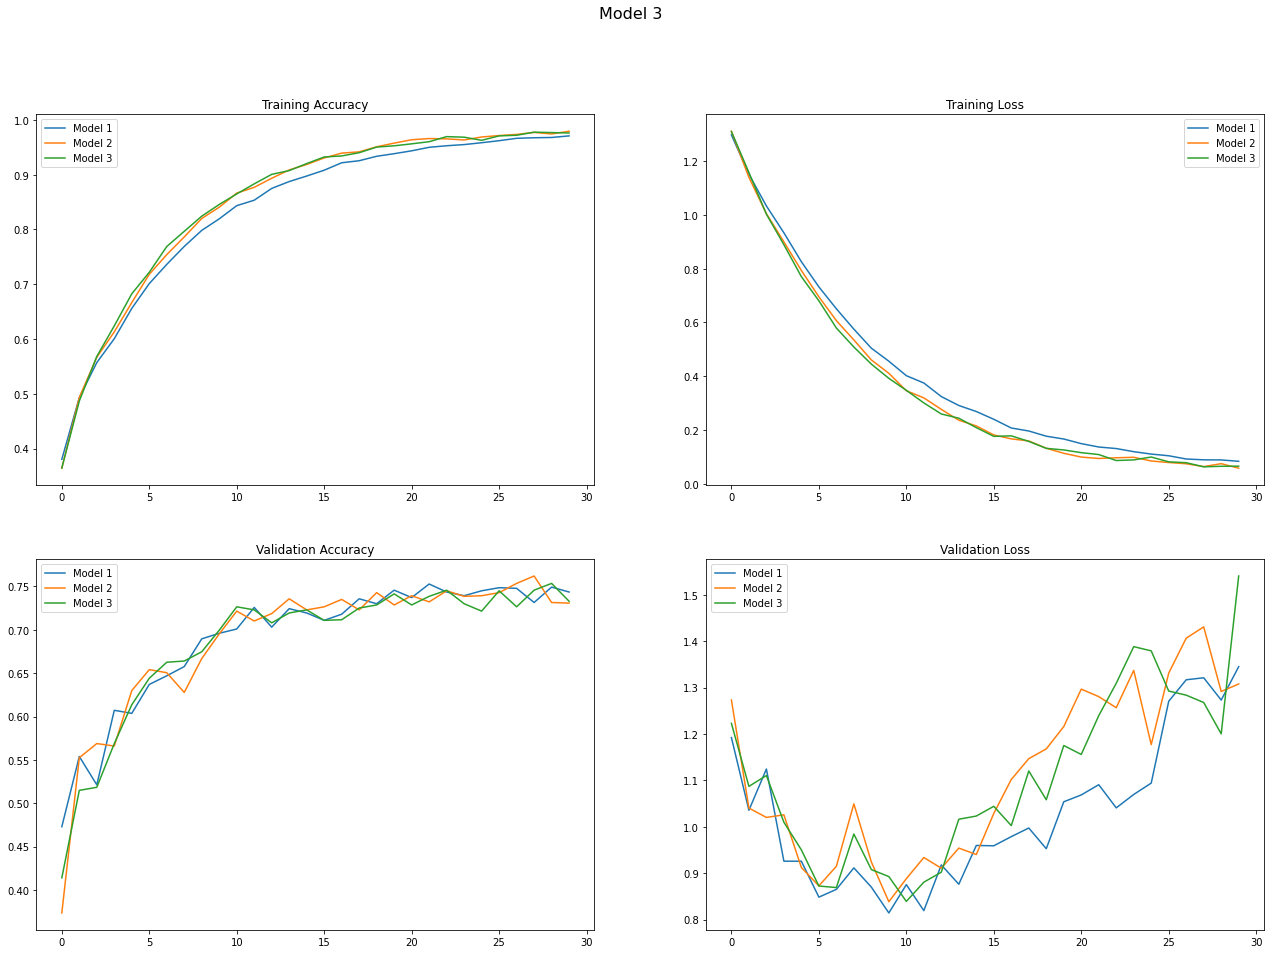

In [ ]:
plt.figure(figsize = (22,15))

# Training Accuracy
plt.subplot(2,2,1)
plt.title('Training Accuracy')
plt.plot(stats_1.history['acc'], label = 'Model 1')
plt.plot(stats_2.history['acc'], label = 'Model 2')
plt.plot(stats_3.history['acc'], label = 'Model 3')
plt.legend()

# Training Loss
plt.subplot(2,2,2)
plt.title('Training Loss')
plt.plot(stats_1.history['loss'], label = 'Model 1')
plt.plot(stats_2.history['loss'], label = 'Model 2')
plt.plot(stats_3.history['loss'], label = 'Model 3')
plt.legend()

# Validation Accuracy
plt.subplot(2,2,3)
plt.title('Validation Accuracy')
plt.plot(stats_1.history['val_acc'], label = 'Model 1')
plt.plot(stats_2.history['val_acc'], label = 'Model 2')
plt.plot(stats_3.history['val_acc'], label = 'Model 3')
plt.legend()

# Validation Loss
plt.subplot(2,2,4)
plt.title('Validation Loss')
plt.plot(stats_1.history['val_loss'], label = 'Model 1')
plt.plot(stats_2.history['val_loss'], label = 'Model 2')
plt.plot(stats_3.history['val_loss'], label = 'Model 3')
plt.legend()

plt.suptitle('Model Performances', fontsize=32)